In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

from pathlib import Path

In [2]:
dataset = Path('../input/three sounds/Three Sounds')

In [3]:
labels = [folder.name for folder in dataset.glob('*')]
frame_files, frame_labels = [], []
for folder in dataset.glob('*'):
    files = [path for path in folder.glob('*')]
    frame_files.extend(files)
    frame_labels.extend([folder.name] * len(files))

frame = [frame_files, frame_labels]

In [4]:
labels

['Conga', 'Snare', 'Kick']

In [5]:
# TODO: Figure out a better way to create this Dataframe
df = pd.DataFrame()
df['Path'] = frame_files
df['Label'] = frame_labels

# Feature Extraction

In [6]:
df.head()

,Path,Label
0,../input/three sounds/Three Sounds/Conga/HR16B...,Conga
1,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga
2,../input/three sounds/Three Sounds/Conga/DDM22...,Conga
3,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga
4,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga


In [7]:
%%time
def feats_extraction(path):
    raw_signal, sample_rate = librosa.load(path)
    mfccs = librosa.feature.mfcc(raw_signal, sample_rate) # 20 features (default)
    chroma = librosa.feature.chroma_stft(raw_signal, sample_rate) # 12 features
    stft = np.abs(librosa.stft(raw_signal))
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate) # 7 features
    return np.concatenate([mfccs, chroma, contrast]) # Total of 39 features per sample



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


In [8]:
df['feats_raw'] = df.Path.apply(feats_extraction)

/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


# Features per File
Here we see that extracted values from each data sample has varying length. That is because in each sound, the features are extracted per sample rate.


In [9]:
df.feats_raw.apply(np.shape).head()

0    (39, 10)
1    (39, 33)
2    (39, 13)
3    (39, 33)
4    (39, 20)
Name: feats_raw, dtype: object

In [10]:
def pre_process(feature_matrix):
    feats = [
        feature_matrix.mean(axis=1),
        feature_matrix.std(axis=1),
        feature_matrix.min(axis=1),
        feature_matrix.max(axis=1),
        np.median(feature_matrix, axis=1)
    ]
    return np.stack(feats).flatten().astype(np.float32)

In [11]:
df['feats'] = df.feats_raw.apply(pre_process)

# Total Features per row

In [12]:
df.head(2)

,Path,Label,feats_raw,feats
0,../input/three sounds/Three Sounds/Conga/HR16B...,Conga,"[[8.833831787109375, -42.088199615478516, -174...","[-298.05792, 95.76708, -20.481312, -22.881582,..."
1,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga,"[[-222.9587860107422, -259.4712219238281, -434...","[-589.03467, 17.177969, 13.053737, 17.017107, ..."


In [13]:
df.feats[0].shape

(195,)

# Encoding Target

In [14]:
def one_hot_encode(df, labels):
    encoded_labels = [np.zeros(len(labels), dtype='float32') for i in range(len(df))]
    for idx, val in enumerate(df['Label']):
        encoded_labels[idx][labels.index(val)] = 1
    return encoded_labels

In [15]:
df['Target'] = one_hot_encode(df, labels)

In [16]:
df.head()

,Path,Label,feats_raw,feats,Target
0,../input/three sounds/Three Sounds/Conga/HR16B...,Conga,"[[8.833831787109375, -42.088199615478516, -174...","[-298.05792, 95.76708, -20.481312, -22.881582,...","[1.0, 0.0, 0.0]"
1,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga,"[[-222.9587860107422, -259.4712219238281, -434...","[-589.03467, 17.177969, 13.053737, 17.017107, ...","[1.0, 0.0, 0.0]"
2,../input/three sounds/Three Sounds/Conga/DDM22...,Conga,"[[11.414876937866211, -36.395416259765625, -20...","[-278.45374, 132.94608, 28.47263, 16.033699, 1...","[1.0, 0.0, 0.0]"
3,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga,"[[-94.05001068115234, -144.79180908203125, -34...","[-578.8098, -4.518221, 5.153713, -4.403067, -2...","[1.0, 0.0, 0.0]"
4,../input/three sounds/Three Sounds/Conga/MaxV ...,Conga,"[[-9.477093696594238, -53.63145065307617, -195...","[-334.44955, 108.17374, 49.541622, 24.870718, ...","[1.0, 0.0, 0.0]"


# Splitting Dataset

In [17]:
indexes = np.arange(len(df))
np.random.seed(4) #to ensure values say in the same set during each run and not mix up with other parameters
np.random.shuffle(indexes)

val_pivot = int(0.7*len(df))
test_pivot = int(0.85*len(df))

# val_pivot = int(num1*len(df))
# test_pivot = int(num2*len(df))

train_indexes = indexes[0:val_pivot] # 70% of dataset
val_indexes = indexes[val_pivot:test_pivot] # 15% of dataset
test_intexes = indexes[test_pivot:] # 15% of dataset

In [18]:
df_train = df.iloc[train_indexes].reset_index(drop=True)
df_val = df.iloc[val_indexes].reset_index(drop=True)
df_test = df.iloc[test_intexes].reset_index(drop=True)

In [19]:
train_x, train_y = np.stack(df_train['feats']), np.stack(df_train['Target'])
val_x, val_y = np.stack(df_val['feats']), np.stack(df_val['Target'])
test_x, test_y = np.stack(df_test['feats']), np.stack(df_test['Target'])

In [20]:
df_test.head()

,Path,Label,feats_raw,feats,Target
0,../input/three sounds/Three Sounds/Snare/MaxV ...,Snare,"[[-6.755455017089844, 4.076188087463379, -39.3...","[-129.5107, 13.090422, -57.29045, -18.167854, ...","[0.0, 1.0, 0.0]"
1,../input/three sounds/Three Sounds/Snare/RY30S...,Snare,"[[53.922080993652344, 61.7700309753418, 49.990...","[-89.89738, 38.896896, 6.7960105, 34.293762, 6...","[0.0, 1.0, 0.0]"
2,../input/three sounds/Three Sounds/Snare/Drumu...,Snare,"[[2.6553924083709717, -21.465852737426758, -86...","[-97.766624, 37.39725, 12.874951, 53.170284, 7...","[0.0, 1.0, 0.0]"
3,../input/three sounds/Three Sounds/Snare/MaxV ...,Snare,"[[62.54996871948242, 47.000675201416016, 30.00...","[-39.352863, 26.458838, 19.381712, 38.533146, ...","[0.0, 1.0, 0.0]"
4,../input/three sounds/Three Sounds/Kick/XR10Ki...,Kick,"[[80.26639556884766, 45.581844329833984, -28.6...","[-164.52576, 57.540226, -12.984634, 44.450302,...","[0.0, 0.0, 1.0]"


In [21]:
train_x.shape, val_x.shape, test_x.shape 

((779, 195), (167, 195), (167, 195))

In [22]:
train_y.shape

(779, 3)

# Building Model

In [23]:
from keras.models import Model, Sequential
from keras.layers import Input,Dense,Dropout

Using TensorFlow backend.


In [24]:
Output_num = len(df['Target'][0])
Output_num

3

In [25]:
#This returns a tensor
# inputs = Input(shape=(train_x.shape[1],))

model = Sequential()
model.add(Dense(128, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.30))
model.add(Dense(64, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.10))
model.add(Dense(Output_num, activation='softmax'))

# # a layer instance is callable on a tensor, and returns a tensor
# x = Dense(64, activation='relu')(inputs)
# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros")(inputs)
# x = Dense(64, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros")(x)
# x = Dense(64, activation='relu',kernel_initializer="random_uniform", bias_initializer="zeros")(x)
# predictions = Dense(Output_num, activation='softmax')(x)
#predictions = Dense(3, activation='softmax')(x)
# predictions = Dense(2, activation='softmax')(inputs)

# # This creates a model that includes
# # the Input layer and three Dense layers
# model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# print(model.summary())

In [26]:
results_val = model.fit(train_x, train_y, validation_data=(val_x,val_y), epochs=200, batch_size=64) # starts training with validating

Train on 779 samples, validate on 167 samples
Epoch 1/200
779/779 [==============================] - 2s 3ms/step - loss: 0.7009 - acc: 0.7471 - val_loss: 0.2651 - val_acc: 0.8922
Epoch 2/200
779/779 [==============================] - 0s 68us/step - loss: 0.3722 - acc: 0.8691 - val_loss: 0.1856 - val_acc: 0.9581
Epoch 3/200
779/779 [==============================] - 0s 68us/step - loss: 0.2467 - acc: 0.9089 - val_loss: 0.1520 - val_acc: 0.9521
Epoch 4/200
779/779 [==============================] - 0s 65us/step - loss: 0.2500 - acc: 0.9140 - val_loss: 0.2135 - val_acc: 0.9401
Epoch 5/200
779/779 [==============================] - 0s 59us/step - loss: 0.2182 - acc: 0.9243 - val_loss: 0.1475 - val_acc: 0.9461
Epoch 6/200
779/779 [==============================] - 0s 59us/step - loss: 0.1991 - acc: 0.9307 - val_loss: 0.2206 - val_acc: 0.9102
Epoch 7/200
779/779 [==============================] - 0s 59us/step - loss: 0.1822 - acc: 0.9461 - val_loss: 0.4016 - val_acc: 0.8743
Epoch 8/200
779/7

In [27]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               25088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total para

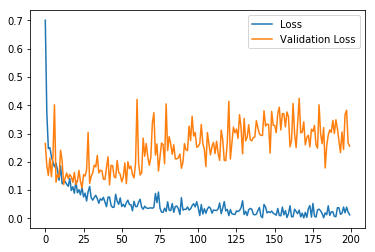

In [28]:
x_axis = np.arange(200)
plt.plot(x_axis, results_val.history['loss'], x_axis, results_val.history['val_loss'])
plt.gca().legend(('Loss','Validation Loss'))

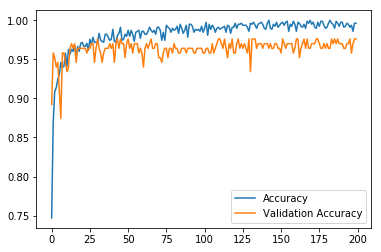

In [29]:
x_axis = np.arange(200)
plt.plot(x_axis, results_val.history['acc'], x_axis, results_val.history['val_acc'])
plt.gca().legend(('Accuracy','Validation Accuracy'))

In [30]:
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
train_loss, train_acc = model.evaluate(train_x, train_y, verbose=0)

In [31]:
print('Test accuracy:', test_acc)
print('Train accuracy:', train_acc)

Test accuracy: 0.9820359281437125
Train accuracy: 1.0


# Make Predictions

In [32]:
predictions = model.predict(test_x)

In [33]:
rounded_predictions = model.predict_classes(test_x)

In [34]:
rounded_predictions[0]

1

In [35]:
predictions[1]

array([5.3024794e-23, 1.0000000e+00, 3.5245566e-14], dtype=float32)

In [36]:
np.argmax(predictions[1])

1

In [37]:
np.argmax(test_y[0])

1

In [38]:
counter = 0
for i in range(len(test_y)):
    if (np.argmax(predictions[i]) == np.argmax(test_y[i])):
        counter = counter + 1
print(counter)

164


In [39]:
snareCounter = 0
for i in range(len(df_test)):
    if (df_test['Label'][i] == 'Snare'):
        snareCounter = snareCounter + 1
print(snareCounter)

92


# Creating a table

In [40]:
names = []
names = os.listdir(dataset)
names

['Conga', 'Snare', 'Kick']

In [41]:
test_y[9]

array([0., 0., 1.], dtype=float32)

In [42]:
#notetoself make this dynamic
namescounter = []
namesperc = []
namesmatch = []
for i in range(len(names)):
    namescounter.append(i)
    namesperc.append(i)
    namesmatch.append(i)
    namescounter[i]= 0
    namesperc[i] = 0
    namesmatch[i] = 0

for i in range(len(test_y)):
    if np.all(test_y[i] == [1.0, 0.0, 0.0]):
        namescounter[0] += 1
        if(np.argmax(predictions[i]) == np.argmax(test_y[i])):
            namesmatch[0] += 1
    if np.all(test_y[i] == [0.0, 1.0, 0.0]):
        namescounter[1] += 1
        if(np.argmax(predictions[i]) == np.argmax(test_y[i])):
            namesmatch[1] += 1
    if np.all(test_y[i] == [0.0, 0.0, 1.0]):
        namescounter[2] += 1
        if(np.argmax(predictions[i]) == np.argmax(test_y[i])):
            namesmatch[2] += 1

for i in range(len(namesmatch)):
    print(namescounter[i])
    print(names[i],': ', namesmatch[i])

14
Conga :  12
92
Snare :  92
61
Kick :  60


In [43]:
for i in range(len(names)):
    namesperc[i] = round(namesmatch[i]/namescounter[i], 2)
    print(namesperc[i])

0.86
1.0
0.98


In [44]:
data = []
for i in range(len(names)):
    data.append([names[i], namescounter[i], namesmatch[i], namesperc[i]])
    print(data[i])


['Conga', 14, 12, 0.86]
['Snare', 92, 92, 1.0]
['Kick', 61, 60, 0.98]


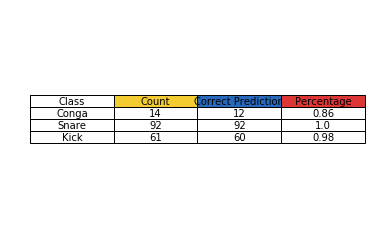

In [45]:
table = plt.table(cellText=data, colLabels = ['Class','Count','Correct Prediction','Percentage'], loc='center', 
                  cellLoc='center', colColours=['#FFFFFF', '#F3CC32', '#2769BD', '#DC3735'])
table.auto_set_font_size(False)

plt.axis('off')
plt.show()


# Confusion Matrix

In [46]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [47]:
name = [folder.name for folder in dataset.glob('*')]
name

['Conga', 'Snare', 'Kick']

In [48]:
rounded_labels = []
for i in range(len(test_y)):
    rounded_labels.append(np.argmax(test_y[i]))
print(rounded_labels[0])

1


In [49]:
conmatrix = confusion_matrix(rounded_labels, rounded_predictions)

Text(0.5, 0, 'Predicted Label')

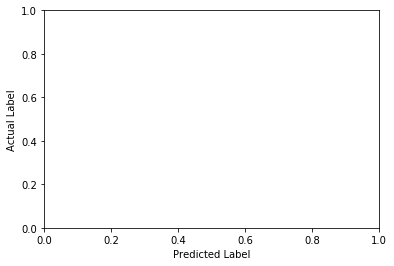

In [50]:
def plot_confusion_matrix(conmatrix, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

    
    plt.imshow(conmatrix, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        conmatrix = conmatrix.astype('float') / conmatrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conmatrix)


    thresh = conmatrix.max() / 2.
    for i in range(conmatrix.shape[0]):
        for j in range(conmatrix.shape[1]):
            plt.text(j, i, conmatrix[i, j],
                    
                     horizontalalignment = "center",
                    color="white" if conmatrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

Confusion matrix, without normalization
[[12  0  2]
 [ 0 92  0]
 [ 0  1 60]]


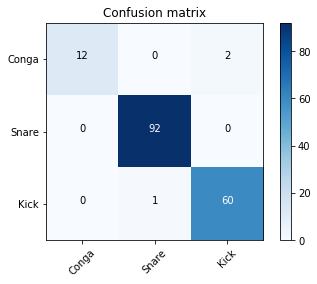

In [51]:
conmatrix_labels = [nam for nam in name]
plot_confusion_matrix(conmatrix, conmatrix_labels, title='Confusion matrix')

# Saving the model

In [52]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [53]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
